In [1]:
import hdf5plugin
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scanpy.external as sce
import matplotlib.pyplot as plt

### Load Dataset 

In [2]:
adata = sc.read('./pancreas_data.h5ad')
adata

AnnData object with n_obs × n_vars = 3179 × 31884
    obs: 'batch', 'celltype', 'disease', 'donor', 'protocol'

In [3]:
adata.obs["batch"].value_counts()

batch
pancreas_gse81547    2544
pancreas_gse83139     635
Name: count, dtype: int64

### Preprocessing

In [4]:
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[:, [gene for gene in adata.var_names if not str(gene).startswith(tuple(['ERCC', 'MT-', 'mt-']))]]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

c:\Users\kostas\prj\texnologia_logismikou_project_2025\python_src\.venv\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\kostas\prj\texnologia_logismikou_project_2025\python_src\.venv\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


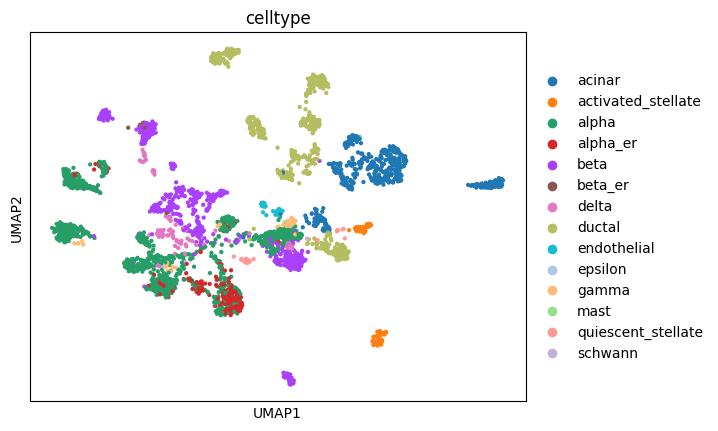

In [5]:
sc.pl.umap(adata,color=['celltype'],legend_fontsize=10)

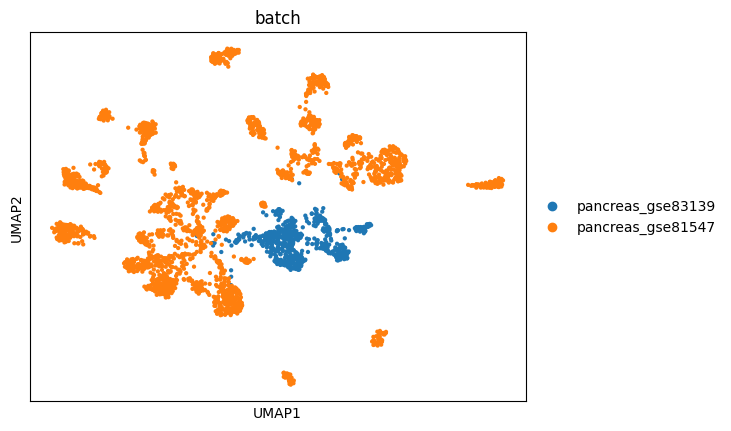

In [6]:
sc.pl.umap(adata,color=['batch'],legend_fontsize=10)

In [ ]:
adata

### Data Integration (Harmony)

### scRNA data integration

In [ ]:
sce.pp.harmony_integrate(adata, 'batch')

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata,color=['batch'],legend_fontsize=10)

In [ ]:
sc.pl.umap(adata,color=['celltype'],legend_fontsize=10)

### Differential Expression Analysis

In [ ]:
sc.tl.rank_genes_groups(
    adata,
    groupby='disease',             # the column in adata.obs
    method='wilcoxon',           
    groups=['case'],             # test 'case' vs 'control'
    reference='control',         # control group
    use_raw=False                # set True if you stored normalized counts in .raw
)

In [ ]:
deg_result = adata.uns["rank_genes_groups"]

degs_df = pd.DataFrame(
        {
            "genes": deg_result["names"]["case"],
            "pvals": deg_result["pvals"]["case"],
            "pvals_adj": deg_result["pvals_adj"]["case"],
            "logfoldchanges": deg_result["logfoldchanges"]["case"],
        }
    )

In [ ]:
degs_df

In [ ]:
degs_df["neg_log10_pval"] = -np.log10(degs_df["pvals"])

# Add a column for differential expression classification
degs_df["diffexpressed"] = "NS"
degs_df.loc[(degs_df["logfoldchanges"] > 1) & (degs_df["pvals"] < 0.05), "diffexpressed"] = "UP"
degs_df.loc[(degs_df["logfoldchanges"] < -1) & (degs_df["pvals"] < 0.05), "diffexpressed"] = "DOWN"

# Select top downregulated genes (prioritize by highest significance, then most negative log2FC)
top_downregulated = degs_df[degs_df["diffexpressed"] == "DOWN"]
top_downregulated = top_downregulated.sort_values(by=["neg_log10_pval", "logfoldchanges"], ascending=[False, True]).head(20)

# Select top upregulated genes (prioritize by highest significance, then most positive log2FC)
top_upregulated = degs_df[degs_df["diffexpressed"] == "UP"]
top_upregulated = top_upregulated.sort_values(by=["neg_log10_pval", "logfoldchanges"], ascending=[False, False]).head(81)

# Combine top genes
top_genes_combined = pd.concat([top_downregulated["genes"], top_upregulated["genes"]])
df_annotated = degs_df[degs_df["genes"].isin(top_genes_combined)]

In [ ]:
# Create Volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=degs_df, x="logfoldchanges", y="neg_log10_pval", hue="diffexpressed", palette={"UP": "#bb0c00", "DOWN": "#00AFBB", "NS": "grey"}, alpha=0.7, edgecolor=None)

# Add threshold lines
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='dashed')
plt.axvline(x=-1, color='gray', linestyle='dashed')
plt.axvline(x=1, color='gray', linestyle='dashed')

# Labels and formatting
plt.xlim(-11, 11)
plt.ylim(25, 175)
plt.xlabel("log2 Fold Change", fontsize=14)
plt.ylabel("-log10 p-value", fontsize=14)
plt.title("Volcano of DEGs (Disease vs Control)", fontsize=16)
plt.legend(title="Expression", loc="upper right")

plt.show()